## **Setup**

Setting up libraries and loading dataframe

In [31]:
!pip install optuna
!pip install xgboost

In [32]:
# Loading all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit # Like train_test_split but for time series data

# Preprocessing
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline


# Sampling
from sklearn.kernel_approximation import RBFSampler
from sklearn.calibration import CalibratedClassifierCV

# Import evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, confusion_matrix,
                            classification_report, roc_curve, auc, roc_auc_score)
from sklearn.model_selection import cross_validate, cross_val_predict




# Random Seed
seed = 42

In [33]:
import xgboost as xgb
import re
import optuna
from sklearn.metrics import log_loss

In [34]:
# Load dataset
url='https://drive.google.com/file/d/1df3HKtpV0YCsf3uiQ6mgmptk0dn4Xtev/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

# Clean up feature names immediately after loading
df.columns = [re.sub(r'<', '_under_', col) for col in df.columns]
df.columns = [re.sub(r'>', '_over_', col) for col in df.columns]

df.columns

Index(['Date', 'Div_enc', 'HomeTeam_enc', 'AwayTeam_enc', 'Season', 'Over2.5',
       'AvgH', 'AvgD', 'AvgA', 'Avg_over_2.5', 'Avg_under_2.5', 'AHh',
       'AvgAHH', 'AvgAHA', 'AvgCH', 'AvgCD', 'AvgCA', 'AvgC_over_2.5',
       'AvgC_under_2.5', 'AHCh', 'AvgCAHH', 'AvgCAHA',
       'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
       'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
       'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
       'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
       'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
       'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
       'avg_total_goals_home_5', 'avg_total_goals_away_5', 'win_rate_home_5',
       'win_rate_away_5', 'Over2.5_home_5', 'Over2.5_away_5',
       'gd_last_game_home', 'gd_last_game_away', 'recent_goal_trend_home',
       'recent_goal_trend_away', 'recent_hs_trend_home',
       'rece

# Data manipulation

Creating day and month feature - potentially useful

In [35]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Day'] = df['Date'].dt.day.astype('int64')
df['Month'] = df['Date'].dt.month.astype('int64')
df['Year'] = df['Date'].dt.year
print(df['Year'].unique())


print(df.columns)

[2019 2020 2021 2022 2023 2024 2025]
Index(['Date', 'Div_enc', 'HomeTeam_enc', 'AwayTeam_enc', 'Season', 'Over2.5',
       'AvgH', 'AvgD', 'AvgA', 'Avg_over_2.5', 'Avg_under_2.5', 'AHh',
       'AvgAHH', 'AvgAHA', 'AvgCH', 'AvgCD', 'AvgCA', 'AvgC_over_2.5',
       'AvgC_under_2.5', 'AHCh', 'AvgCAHH', 'AvgCAHA',
       'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
       'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
       'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
       'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
       'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
       'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
       'avg_total_goals_home_5', 'avg_total_goals_away_5', 'win_rate_home_5',
       'win_rate_away_5', 'Over2.5_home_5', 'Over2.5_away_5',
       'gd_last_game_home', 'gd_last_game_away', 'recent_goal_trend_home',
       'recent_goal_trend_away',

Sort the data and create train and test set

In [36]:
#Sort chronologically
df = df.sort_values('Date').reset_index(drop=True)


cut_date = df['Date'].quantile(0.85)  # last 15% as test
train_idx = df['Date'] < cut_date
test_idx  = df['Date'] >= cut_date

df = df.drop(['Date', 'Year'], axis=1)
print(cut_date)

2024-09-14 00:00:00


In [37]:
target = 'Over2.5'
X = df.drop(target, axis=1)
y = df[target]


X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]



Check format

In [38]:
# Display data types for debugging
print("Data types of X_train columns:")
print(X_train.dtypes)

# Display count of each data type
print("\nValue counts of data types in X_train:")
print(X_train.dtypes.value_counts())



Data types of X_train columns:
Div_enc               int64
HomeTeam_enc          int64
AwayTeam_enc          int64
Season                int64
AvgH                float64
                     ...   
Country_Scotland       bool
Country_Spain          bool
Country_Turkey         bool
Day                   int64
Month                 int64
Length: 86, dtype: object

Value counts of data types in X_train:
float64    70
bool       10
int64       6
Name: count, dtype: int64


All good :)

# Function to compare results

Will be used for the upcoming models

In [39]:
def evaluate_model(model):
  # Get predictions
  y_pred_test = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  # Calculate accuracy
  accuracy_test = accuracy_score(y_test, y_pred_test)
  accuracy_train = accuracy_score(y_train, y_pred_train)

  # Print accuracy
  print(f"Test Accuracy: {accuracy_test}")
  print(f"Train Accuracy: {accuracy_train}")

  # Plot ROC Curve (if model has predict_proba)
  if hasattr(model, 'predict_proba') and model.predict_proba(X_test).shape[1] > 1:
      y_pred_proba_test = model.predict_proba(X_test)[:, 1]
      y_pred_proba_train = model.predict_proba(X_train)[:, 1]

      fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
      roc_auc = auc(fpr, tpr)
      fpr_train, tpr_train, thresholds = roc_curve(y_train, y_pred_proba_train)
      roc_auc_train = auc(fpr_train, tpr_train)


      plt.figure()
      plt.plot(fpr, tpr, label=f'Test ROC curve (area = {roc_auc:.2f})')
      plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
      plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curve')
      plt.legend(loc='lower right')
      plt.show()
  else:
      print("ROC curve cannot be plotted as the model does not have predict_proba or does not return probabilities for both classes.")

# XGBOOST models

Basic xgboost - no tuning of hyperparametres





In [40]:
# define the model
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              random_state=seed
                              )


# fit the model
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Test Accuracy: 0.5432504301579852
Train Accuracy: 0.806573887059735


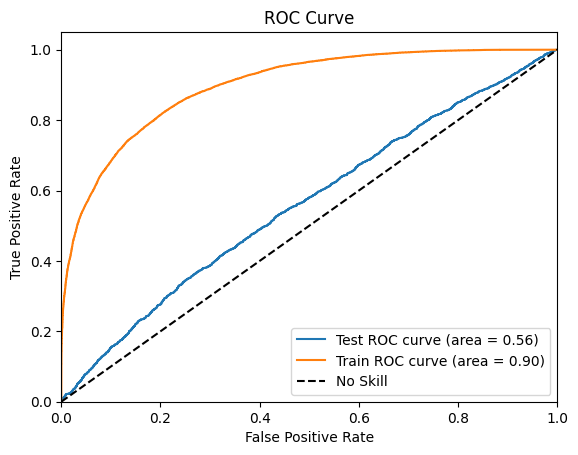

In [41]:
evaluate_model(model_xgb)

We can see that this model is predicting pretty well but overfits.

Lets create a second model which will have the hyperparametrs adjusted to prevent overfitting.

Test Accuracy: 0.5579540122008447
Train Accuracy: 0.6423373820656836


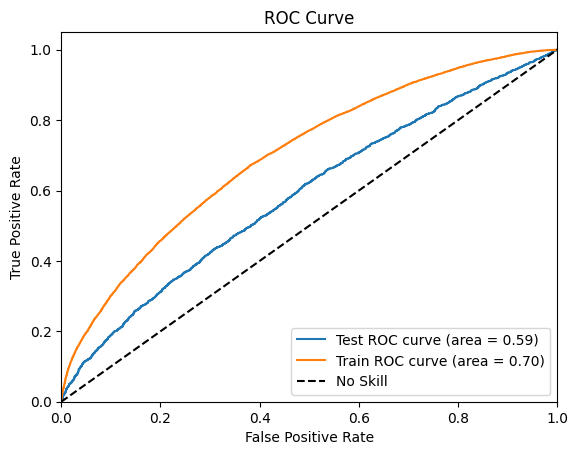

In [42]:
model_xgb_antiOF = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',     # keeps training sane
    tree_method='hist',
    random_state=seed,

    # --- anti-overfit defaults ---
    learning_rate=0.05,        # smaller steps
    n_estimators=800,           # modest since no early stopping

    max_depth=3,               # shallow trees generalize
    min_child_weight=20,       # need enough samples to split

    subsample=0.7,             # row subsampling
    colsample_bytree=0.7,      # feature subsampling
    colsample_bynode=0.8,      # extra randomness per split

    gamma=1.0,                 # require worthwhile loss drop
    reg_lambda=20.0,           # L2
    reg_alpha=0.5              # a bit of L1
)

model_xgb_antiOF.fit(X_train, y_train)
evaluate_model(model_xgb_antiOF)

# Hyperparameter tuning

Lets try to do some hyperparameter tuning with the bayesian optimization. We will use the package optuna which we also need to install.

In [43]:
pip install optuna

For adjusting the hyperparameters we also need the validation set which is here being created as a part of the train set.

In [44]:
cut = int(len(X_train) * 0.85)
X_tr,   X_eval   = X_train.iloc[:cut], X_train.iloc[cut:]
y_tr,   y_eval   = y_train.iloc[:cut], y_train.iloc[cut:]


This part of the code uses Optuna to tune XGBoost hyperparameters on a single train/eval split: for each trial it trains up to 3000 trees with early stopping (100 rounds) on X_eval, y_eval, returning the logloss on that eval set. It also records the trial’s best boosting rounds (trees at the early-stopped optimum). After 40 trials, it reports the best hyperparameters, the best eval logloss, and the selected number of trees.

In [45]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'eta': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),  # learning_rate
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
        'alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'verbosity': 0
    }

    dtrain = xgb.DMatrix(X_tr,   label=y_tr)
    deval  = xgb.DMatrix(X_eval, label=y_eval)

    num_boost_round = 3000
    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(deval, 'eval')],
        early_stopping_rounds=100,   # patience
        verbose_eval=False
    )

    # Best rounds
    best_rounds = getattr(booster, 'best_iteration', None)
    if best_rounds is None:
        best_rounds = getattr(booster, 'best_ntree_limit', num_boost_round)

    trial.set_user_attr('best_rounds', int(best_rounds))

    # Predict on eval using the best number of trees
    try:
        proba = booster.predict(deval, iteration_range=(0, int(best_rounds)))
    except TypeError:
        proba = booster.predict(deval, ntree_limit=int(best_rounds))

    return float(log_loss(y_eval, proba))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=40, show_progress_bar=True)

best_params = study.best_params
best_rounds = int(study.best_trial.user_attrs.get('best_rounds', 300))

print("Best params:", best_params)
print("Best eval logloss:", study.best_value)
print("Best boosting rounds:", best_rounds)

[I 2025-11-16 17:24:34,797] A new study created in memory with name: no-name-719bc506-71b0-4365-9de3-fad5ecd0dbdd


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-16 17:24:35,664] Trial 0 finished with value: 0.6728708117929993 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 6, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.3119890406724053, 'reg_lambda': 1.2551115172973832, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.6728708117929993.
[I 2025-11-16 17:24:36,267] Trial 1 finished with value: 0.6719646432525798 and parameters: {'learning_rate': 0.06054365855469246, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9162213204002109, 'gamma': 0.4246782213565523, 'reg_lambda': 2.03664420268309, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.6719646432525798.
[I 2025-11-16 17:24:37,194] Trial 2 finished with value: 0.6710191772971166 and parameters: {'learning_rate': 0.024878734419814436, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7164916560792167, 'colsample_bytree'

This block refits the final model on 100% of the training data using the hyperparameters Optuna found, mapping learning_rate → eta, and fixes the number of trees to best_rounds (the early-stopped optimum from tuning). It uses the core xgb.train Booster API (no eval set, no early stopping now), so the model capacity is locked and there’s no leakage.

In [46]:
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'eta': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'lambda': best_params['reg_lambda'],
    'alpha': best_params['reg_alpha'],
    'verbosity': 0,
    'seed': seed,  # Ensure reproducibility
    'random_state': seed  # Ensure reproducibility
}

dfull = xgb.DMatrix(X_train, label=y_train)
final_booster = xgb.train(
    final_params,
    dfull,
    num_boost_round=best_rounds,
    verbose_eval=False
)

And here are the results of the model.

Train Accuracy: 0.585
Test  Accuracy: 0.571


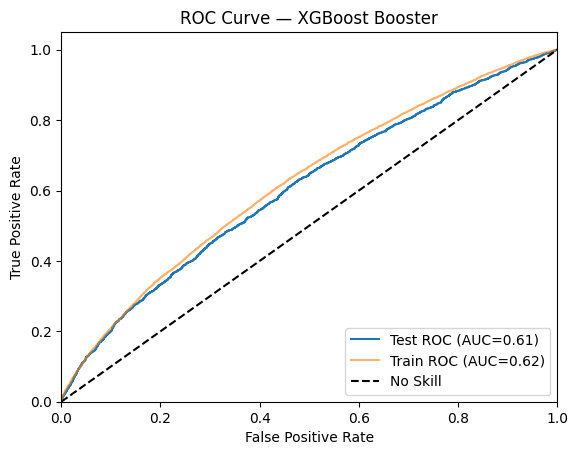

In [47]:
dtrain = xgb.DMatrix(X_train)
dtest  = xgb.DMatrix(X_test)

p_train = final_booster.predict(dtrain)  # P(y=1)
p_test  = final_booster.predict(dtest)   # P(y=1)

y_pred_train = (p_train >= 0.5).astype(int)
y_pred_test  = (p_test  >= 0.5).astype(int)

#Accuracies
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test,  y_pred_test)

print(f"Train Accuracy: {acc_train:.3f}")
print(f"Test  Accuracy: {acc_test:.3f}")

#ROC curves + AUC
fpr_tr, tpr_tr, _ = roc_curve(y_train, p_train)
fpr_te, tpr_te, _ = roc_curve(y_test,  p_test)
auc_tr = auc(fpr_tr, tpr_tr)
auc_te = auc(fpr_te, tpr_te)

plt.figure()
plt.plot(fpr_te, tpr_te, label=f"Test ROC (AUC={auc_te:.2f})")
plt.plot(fpr_tr, tpr_tr, label=f"Train ROC (AUC={auc_tr:.2f})", alpha=0.6)
plt.plot([0, 1], [0, 1], "k--", label="No Skill")
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost Booster")
plt.legend(loc="lower right")
plt.show()


**Crossvalidation**

With CV, we don’t rely on one eval slice—we do time-series cross-validation, training with early stopping on each chronological fold, then average the fold logloss and pick a stable tree count (e.g., median of per-fold best rounds). This reduces “lucky split” variance, better reflects out-of-time performance, and generally curbs overfitting versus a single train/eval split. After tuning, we still refit one final model on all training data using those aggregated hyperparameters and rounds.

Otherwise the code for the tuning is the same and these are the results.

[I 2025-11-16 17:25:19,551] A new study created in memory with name: no-name-95ea6cb0-7237-4318-936f-0a1d75028cbd


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-16 17:25:39,220] Trial 0 finished with value: 0.6760777843475756 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 6, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.3119890406724053, 'reg_lambda': 1.2551115172973832, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.6760777843475756.
[I 2025-11-16 17:25:45,638] Trial 1 finished with value: 0.6765021378403541 and parameters: {'learning_rate': 0.06054365855469246, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9162213204002109, 'gamma': 0.4246782213565523, 'reg_lambda': 2.03664420268309, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 0.6760777843475756.
[I 2025-11-16 17:25:52,416] Trial 2 finished with value: 0.6753443874977532 and parameters: {'learning_rate': 0.024878734419814436, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7164916560792167, 'colsample_bytree'

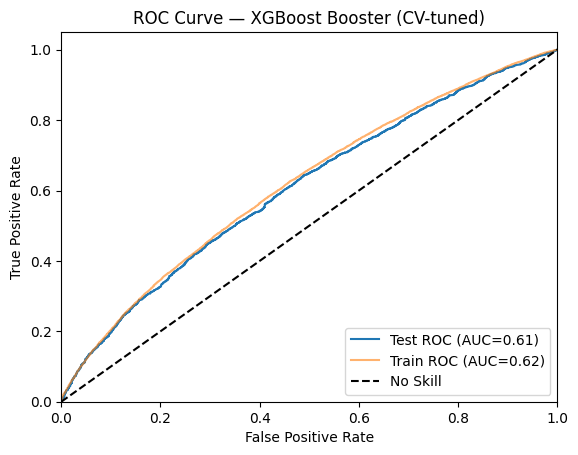

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, accuracy_score, roc_curve, auc
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

# --- Time-series CV folds on TRAIN ONLY ---
tscv = TimeSeriesSplit(n_splits=10)
folds = list(tscv.split(X_train))

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'seed': 42,
        'eta': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
        'alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'verbosity': 0,
        'seed': seed,
        'random_state': seed
    }

    num_boost_round = 3000
    fold_losses = []
    fold_rounds = []

    for tr_idx, va_idx in folds:
        dtr = xgb.DMatrix(X_train.iloc[tr_idx], label=y_train.iloc[tr_idx])
        dva = xgb.DMatrix(X_train.iloc[va_idx], label=y_train.iloc[va_idx])

        booster = xgb.train(
            params,
            dtr,
            num_boost_round=num_boost_round,
            evals=[(dva, 'eval')],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        # best rounds per fold
        best_rounds = getattr(booster, 'best_iteration', None)
        if best_rounds is None:
            best_rounds = getattr(booster, 'best_ntree_limit', num_boost_round)
        best_rounds = int(best_rounds)
        fold_rounds.append(best_rounds)

        # fold loss using best rounds
        try:
            proba = booster.predict(dva, iteration_range=(0, best_rounds))
        except TypeError:
            proba = booster.predict(dva, ntree_limit=best_rounds)
        fold_losses.append(float(log_loss(y_train.iloc[va_idx], proba)))

    median_rounds = int(np.median(fold_rounds))
    trial.set_user_attr('fold_best_rounds', fold_rounds)
    trial.set_user_attr('median_best_rounds', median_rounds)

    return float(np.mean(fold_losses))

# --- Optuna tuning over CV ---
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=40, show_progress_bar=True)

best_params = study.best_params
best_rounds = int(study.best_trial.user_attrs.get('median_best_rounds', 300))
print("Best params:", best_params)
print("CV mean logloss:", study.best_value)
print("Chosen boosting rounds (median across folds):", best_rounds)

# --- FINAL REFIT on 100% of TRAIN (no eval, no early stopping) ---
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'seed': 42,
    'eta': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'lambda': best_params['reg_lambda'],
    'alpha': best_params['reg_alpha'],
    'verbosity': 0,
    'seed': seed,
    'random_state': seed
}

dfull = xgb.DMatrix(X_train, label=y_train)
final_booster = xgb.train(
    final_params,
    dfull,
    num_boost_round=best_rounds,
    verbose_eval=False
)

# --- Evaluate on TRAIN/TEST (probabilities, accuracy, ROC) ---
dtrain = xgb.DMatrix(X_train)
dtest  = xgb.DMatrix(X_test)

p_train = final_booster.predict(dtrain)
p_test  = final_booster.predict(dtest)

y_pred_train = (p_train >= 0.5).astype(int)
y_pred_test  = (p_test  >= 0.5).astype(int)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test,  y_pred_test)
print(f"Train Accuracy: {acc_train:.3f}")
print(f"Test  Accuracy: {acc_test:.3f}")

fpr_tr, tpr_tr, _ = roc_curve(y_train, p_train)
fpr_te, tpr_te, _ = roc_curve(y_test,  p_test)
auc_tr = auc(fpr_tr, tpr_tr)
auc_te = auc(fpr_te, tpr_te)

plt.figure()
plt.plot(fpr_te, tpr_te, label=f"Test ROC (AUC={auc_te:.2f})")
plt.plot(fpr_tr, tpr_tr, label=f"Train ROC (AUC={auc_tr:.2f})", alpha=0.6)
plt.plot([0, 1], [0, 1], "k--", label="No Skill")
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost Booster (CV-tuned)")
plt.legend(loc="lower right")
plt.show()


### Error Analysis

Find accuracy scores of our best model based on country & division

In [ ]:
new_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_test': y_pred_test,
    'Div_enc': X_test['Div_enc'],
})

# Mapping
country_to_code = {
  'Belgium': [0],
  'Germany': [1, 2],
  'England': [3, 4, 5, 6],
  'France': [7, 8],
  'Greece': [9],
  'Italy': [10, 11],
  'Netherland': [12],
  'Portugal': [13],
  'Scotland': [14, 15, 16, 17],
  'Spain': [18, 19],
  'Turkey': [20]
}


# De-Encode
code_to_country = {code: country for country, codes in country_to_code.items() for code in codes}

# Convert your numeric series
new_df["Country"] = new_df["Div_enc"].map(code_to_country)
print(new_df)

       y_test  y_pred_test  Div_enc   Country
36143       1            1        5   England
36144       1            1        5   England
36145       1            0        5   England
36146       1            1        5   England
36147       1            0       17  Scotland
...       ...          ...      ...       ...
42531       1            1       19     Spain
42532       0            1       19     Spain
42533       1            1       19     Spain
42534       1            1       20    Turkey
42535       1            1       20    Turkey

[6393 rows x 4 columns]


In [ ]:
def accuracy(group):
    return pd.Series({'accuracy': accuracy_score(group['y_test'], group['y_pred_test'])})

accuracies = new_df.groupby('Country').apply(accuracy, include_groups=False)
accuracy_report = accuracies.sort_values(by='accuracy', ascending=False)
accuracy_report




,accuracy
Country,
Portugal,0.631970
Belgium,0.613636
Germany,0.611913
France,0.587273
Spain,0.583884
Netherland,0.578755
Turkey,0.577922
Italy,0.571843
England,0.557661


(array([1., 0., 0., 1., 1., 1., 4., 0., 2., 1.]),
 array([0.48341232, 0.49826812, 0.51312391, 0.5279797 , 0.5428355 ,
        0.55769129, 0.57254709, 0.58740288, 0.60225867, 0.61711447,
        0.63197026]),
 <BarContainer object of 10 artists>)

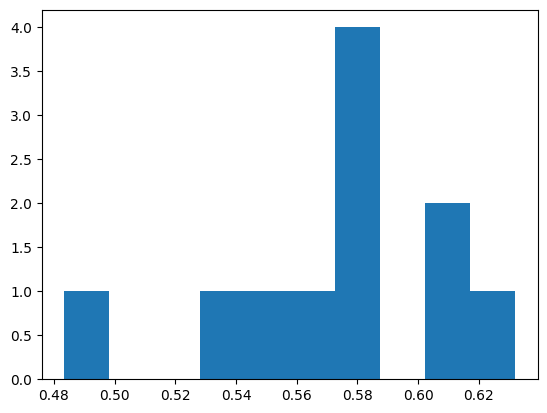

In [ ]:
plt.hist(accuracy_report['accuracy'])

We can see a very big distribution here of our accuracy results across countries. Generally, England & Scotland were our lower scorers, as well as Greece. Portugal, Germany, Belgium were our best ones. Seemingly, the countries with more divisions tend to do the worst. This prompted us to look into changing the way country and divisions are encoded
<br><br>
It follows a relatively normal looking distribution (as normal as 21 datapoints can be that is).

### Finding the feature importance based on the gain in accuracy

In [ ]:
feature_importance = final_booster.get_score(importance_type='gain')
feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(20)

,Feature,Importance
6,AvgC_under_2.5,114.516251
5,AvgC_over_2.5,78.629135
4,AvgCD,17.911911
9,avg_shots_on_target_home_5,14.996531
1,Avg_over_2.5,13.774649
29,Month,12.725815
15,recent_goal_trend_home,12.685547
10,avg_fouls_home_5,12.213427
13,avg_fouls_away_5,11.930852
17,recent_hs_trend_away,11.737865


### SHAP Plot of value importance

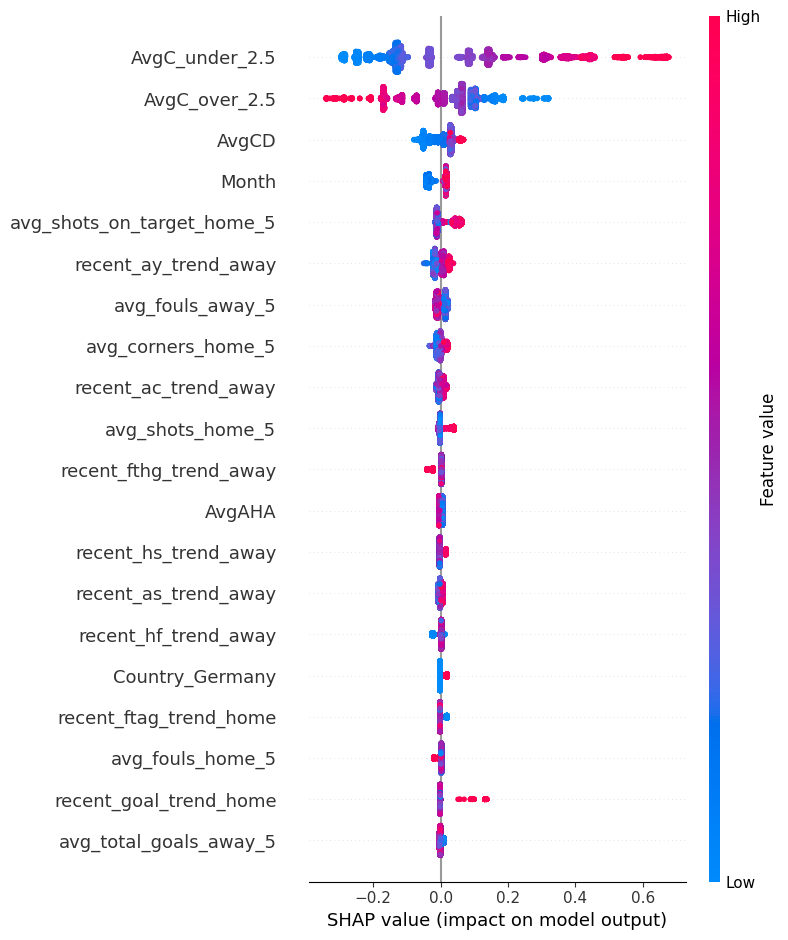

In [ ]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(final_booster)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test)

### Feature Importance by Coverage

In [ ]:
# Extract importance scores (cover)
importance_dict = final_booster.get_score(importance_type='cover')

# Convert to DataFrame
importance_df = (
    pd.DataFrame.from_dict(importance_dict, orient='index', columns=['cover'])
      .reset_index()
      .rename(columns={'index': 'feature'})
      .sort_values(by='cover', ascending=False)
)

print(importance_df.head(20))

                       feature        cover
20        recent_hf_trend_away  6420.296875
15      recent_goal_trend_home  6413.270996
28             Country_Germany  6385.903809
17        recent_hs_trend_away  6283.867676
26      recent_ftag_trend_home  5911.724609
3                       AvgAHA  5905.657715
4                        AvgCD  5767.965332
29                       Month  5291.101074
23        recent_hy_trend_away  5199.687500
13            avg_fouls_away_5  5071.456055
5                AvgC_over_2.5  4981.526855
6               AvgC_under_2.5  4760.989746
10            avg_fouls_home_5  4460.335449
9   avg_shots_on_target_home_5  4391.756836
27      recent_fthg_trend_away  4257.826172
25        recent_ay_trend_away  4191.180664
12     avg_goals_scored_away_5  4165.512207
8             avg_shots_home_5  4064.610840
1                 Avg_over_2.5  3751.032471
18        recent_as_trend_away  2540.806396
